(hierarchical)=
# Hierarchical inference (fixed-d linear regression)


## Import libraries and define constants

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import bayesbridge as bb

In [2]:
M_TRUE = np.array([20, -10, -3, 1])
N_DIMS = len(M_TRUE)
DATA_NOISE_STD = 20

## generate synthetic data

In [3]:
x = np.arange(-5, 10)
fwd_jacobian = np.vander(x, N_DIMS, True)
y = fwd_jacobian @ M_TRUE
y_noisy = y + np.random.normal(0, DATA_NOISE_STD, y.shape)

## define parameters

In [4]:
coefficients_param = bb.parameters.UniformParameter("coefficients", -50, 50, 3)

## define parameterization

In [5]:
param_space = bb.parameterization.ParameterSpace(
    name="my_param_space", 
    n_dimensions=4, 
    parameters=[coefficients_param], 
)
parameterization = bb.parameterization.Parameterization(param_space)

## define forward function

In [6]:
def my_fwd(state: bb.State) -> np.ndarray:
    m = state["my_param_space"]["coefficients"]
    return fwd_jacobian @ m
fwd_functions = [my_fwd]

## define data target

In [7]:
targets = [bb.Target("my_data", y_noisy, std_min=0, std_max=100, std_perturb_std=5)]

## run the sampling

In [8]:
inversion = bb.BayesianInversion(
    parameterization=parameterization, 
    targets=targets, 
    fwd_functions=fwd_functions, 
    n_chains=40, 
    n_cpus=40, 
)
inversion.run(
    sampler=None, 
    n_iterations=100_000, 
    burnin_iterations=10_000, 
    save_every=500, 
    verbose=False, 
)

## get results and plot

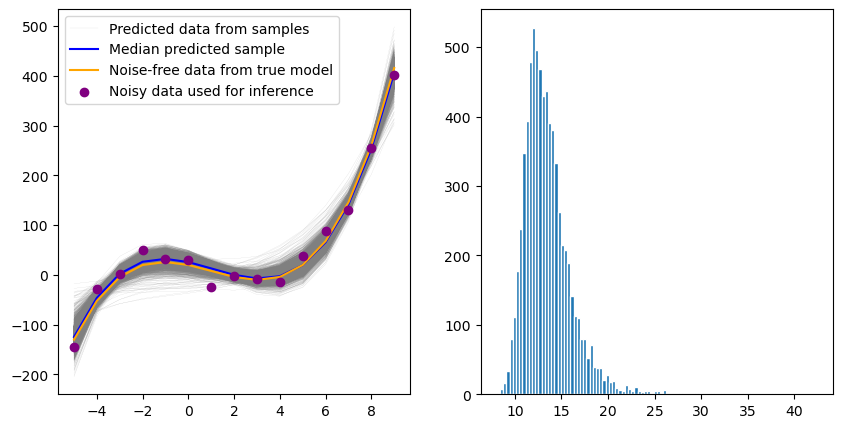

In [9]:
results = inversion.get_results()
coefficients_samples = results["coefficients"]
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
all_y_pred = np.zeros((len(coefficients_samples), len(y)))
for i, coefficients in enumerate(coefficients_samples):
    y_pred = fwd_jacobian @ coefficients
    all_y_pred[i,:] = y_pred
    if i == 0:
        axes[0].plot(x, y_pred, c="gray", lw=0.05, label="Predicted data from samples")
    else:
        axes[0].plot(x, y_pred, c="gray", lw=0.05)
axes[0].plot(x, np.median(all_y_pred, axis=0), c="blue", label="Median predicted sample")
axes[0].plot(x, y, c="orange", label="Noise-free data from true model")
axes[0].scatter(x, y_noisy, c="purple", label="Noisy data used for inference", zorder=3)
axes[0].legend()
axes[1].hist(results["my_data.std"], bins=100, ec="w");